# Scenario Analysis

In this jupyter notebook, the code can be found that was used to perform scenario analysis on the room for the river model used in EPA1361 Model Based Decision making.


In [22]:
#imports
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx

from ema_workbench import (Model, CategoricalParameter,ScalarOutcome, IntegerParameter, RealParameter,
                           MultiprocessingEvaluator, ema_logging, Constant, Policy, Scenario,
                           perform_experiments, SequentialEvaluator,Constraint)
from problem_formulation import get_model_for_problem_formulation

from .rfr_model.dike_model_function #import DikeNetwork  # @UnresolvedImport

from ema_workbench.em_framework.optimization import (HyperVolume, EpsilonProgress,GenerationalBorg)
from ema_workbench.em_framework.evaluators import perform_experiments
from ema_workbench.em_framework.samplers import sample_uncertainties
from ema_workbench.util import ema_logging
from ema_workbench.analysis import plotting, plotting_util, parcoords, feature_scoring, prim
from ema_workbench.analysis import dimensional_stacking

from mpl_toolkits.mplot3d import Axes3D 

import time
import copy

SyntaxError: invalid syntax (Temp/ipykernel_9576/2950649432.py, line 14)

### Run Model 

In [2]:
#running the model through EMA workbench
ema_logging.log_to_stderr(ema_logging.INFO)

#choose problem formulation number, between 0-5
#each problem formulation has its own list of outcomes
dike_model, planning_steps = get_model_for_problem_formulation(3) 


### Load results from previous executed model run

In [3]:
df_experiments_s1000_p10 = pd.read_csv("df_experiments_s1000_p10.csv")
df_outcomes_s1000_p10 = pd.read_csv("df_outcomes_s1000_p10.csv")


In [5]:
print('Outcome keys', df_outcomes_s1000_p10.keys())
print('Experiment keys', df_experiments_s1000_p10.keys())

Outcome keys Index(['Unnamed: 0', 'A.1_Expected Annual Damage', 'A.1_Dike Investment Costs',
       'A.1_Expected Number of Deaths', 'A.2_Expected Annual Damage',
       'A.2_Dike Investment Costs', 'A.2_Expected Number of Deaths',
       'A.3_Expected Annual Damage', 'A.3_Dike Investment Costs',
       'A.3_Expected Number of Deaths', 'A.4_Expected Annual Damage',
       'A.4_Dike Investment Costs', 'A.4_Expected Number of Deaths',
       'A.5_Expected Annual Damage', 'A.5_Dike Investment Costs',
       'A.5_Expected Number of Deaths', 'RfR Total Costs',
       'Expected Evacuation Costs'],
      dtype='object')
Experiment keys Index(['Unnamed: 0', 'A.0_ID flood wave shape', 'A.1_Bmax', 'A.1_Brate',
       'A.1_pfail', 'A.2_Bmax', 'A.2_Brate', 'A.2_pfail', 'A.3_Bmax',
       'A.3_Brate', 'A.3_pfail', 'A.4_Bmax', 'A.4_Brate', 'A.4_pfail',
       'A.5_Bmax', 'A.5_Brate', 'A.5_pfail', 'discount rate 0',
       'discount rate 1', 'discount rate 2', '0_RfR 0', '0_RfR 1', '0_RfR 2',
       

# Initial Feature Scoring

In [9]:
uncertainties_columns = ['A.0_ID flood wave shape', 'A.1_Bmax', 'A.1_Brate', 'A.1_pfail',
       'A.2_Bmax', 'A.2_Brate', 'A.2_pfail', 'A.3_Bmax', 'A.3_Brate',
       'A.3_pfail', 'A.4_Bmax', 'A.4_Brate', 'A.4_pfail', 'A.5_Bmax',
       'A.5_Brate', 'A.5_pfail', 'discount rate 0', 'discount rate 1',
       'discount rate 2'] 
outcomes_of_interest = ['A.4_Expected Annual Damage', 'A.4_Expected Number of Deaths', 'A.4_Dike Investment Costs', 'Expected Evacuation Costs', 'RfR Total Costs']
lever_columns = ['0_RfR 0', '0_RfR 1', '0_RfR 2',
       '1_RfR 0', '1_RfR 1', '1_RfR 2', '2_RfR 0', '2_RfR 1', '2_RfR 2',
       '3_RfR 0', '3_RfR 1', '3_RfR 2', '4_RfR 0', '4_RfR 1', '4_RfR 2',
       'A.1_DikeIncrease 0', 'A.1_DikeIncrease 1', 'A.1_DikeIncrease 2',
       'A.2_DikeIncrease 0', 'A.2_DikeIncrease 1', 'A.2_DikeIncrease 2',
       'A.3_DikeIncrease 0', 'A.3_DikeIncrease 1', 'A.3_DikeIncrease 2',
       'A.4_DikeIncrease 0', 'A.4_DikeIncrease 1', 'A.4_DikeIncrease 2',
       'A.5_DikeIncrease 0', 'A.5_DikeIncrease 1', 'A.5_DikeIncrease 2',
       'EWS_DaysToThreat']

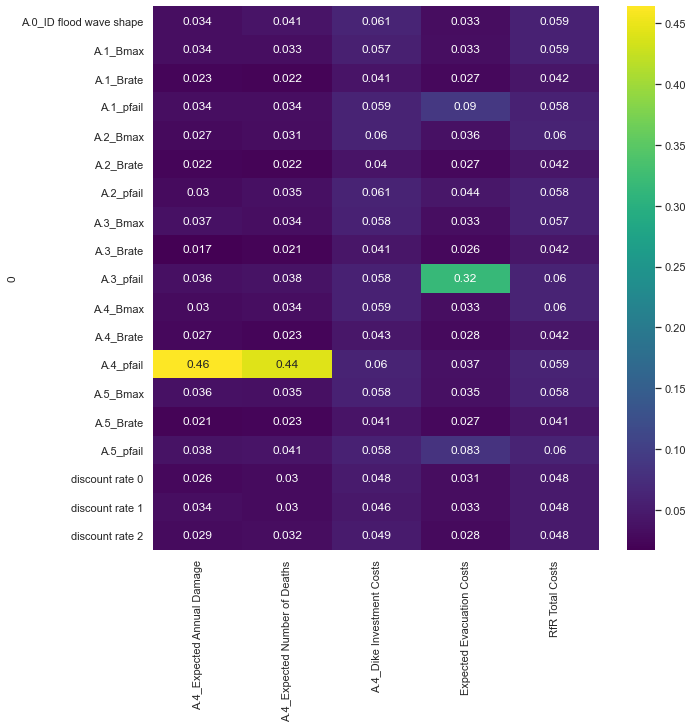

<Figure size 720x720 with 0 Axes>

In [8]:
fs = feature_scoring.get_feature_scores_all(df_experiments_s1000_p10[uncertainties_columns], df_outcomes_s1000_p10[outcomes_of_interest])

sns.set(rc = {'figure.figsize':(10,10)})
sns.heatmap(fs, cmap="viridis", annot=True)
plt.show()
plt.savefig('FeatureScore_s1000_p10')

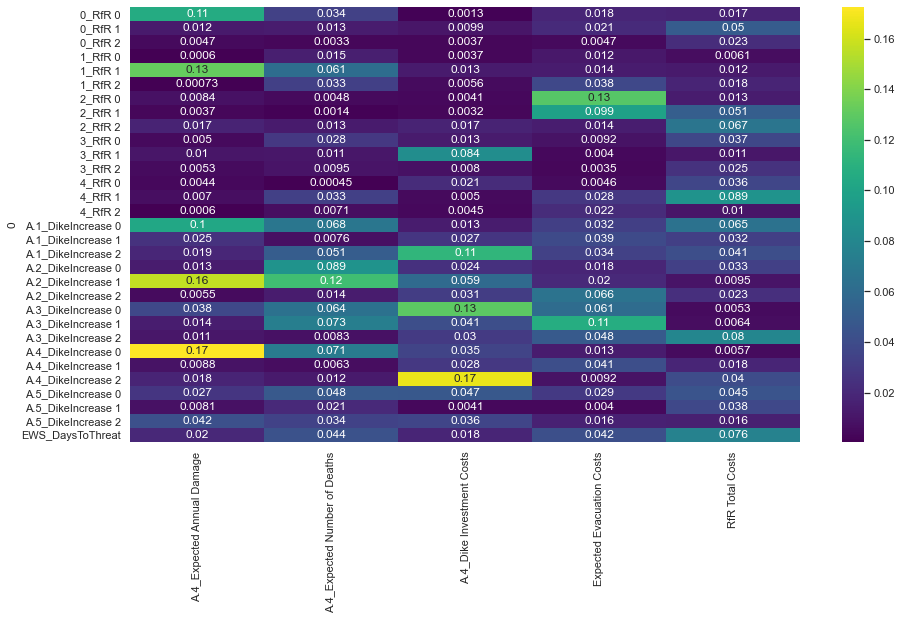

In [11]:
fs = feature_scoring.get_feature_scores_all(df_experiments_s1000_p10[lever_columns], df_outcomes_s1000_p10[outcomes_of_interest])

sns.set(rc = {'figure.figsize':(15,8)})
sns.heatmap(fs, cmap="viridis", annot=True)
plt.show()

In [16]:
for outcome in outcomes_of_interest:
    print('Statistics for : ' , outcome, '\n', df_outcomes_s1000_p10[outcome].describe(), '\n')

Statistics for :  A.4_Expected Annual Damage 
 count    1.000000e+04
mean     9.279252e+05
std      4.821538e+06
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      0.000000e+00
max      1.208495e+08
Name: A.4_Expected Annual Damage, dtype: float64 

Statistics for :  A.4_Expected Number of Deaths 
 count    10000.000000
mean         0.000195
std          0.001138
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          0.020488
Name: A.4_Expected Number of Deaths, dtype: float64 

Statistics for :  A.4_Dike Investment Costs 
 count    1.000000e+04
mean     4.195952e+07
std      9.385170e+06
min      2.511400e+07
25%      3.526125e+07
50%      4.302570e+07
75%      4.943964e+07
max      5.628786e+07
Name: A.4_Dike Investment Costs, dtype: float64 

Statistics for :  Expected Evacuation Costs 
 count    10000.000000
mean      1856.494384
std       5047.661175
min          0.000000
25%          0.000000
50%        124.500

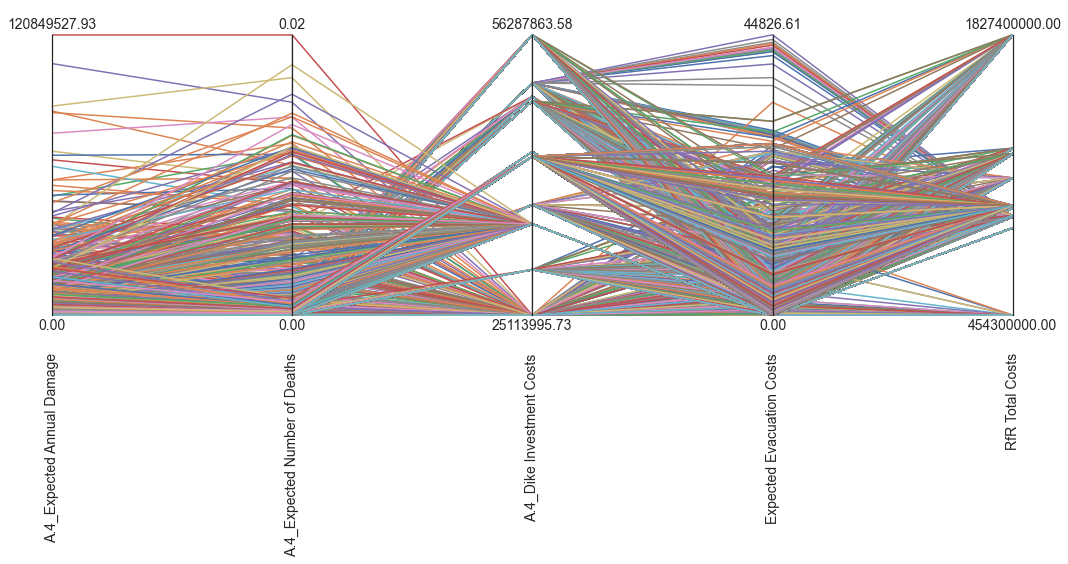

In [17]:
#parallel coordinate plot. In a parallel coordinate plot, the dimensions are visualized side by side.
#Each line represents a scenario that is pareto optimal 

limits = parcoords.get_limits(df_outcomes_s1000_p10[outcomes_of_interest])
axes = parcoords.ParallelAxes(limits)
fig = axes.plot(df_outcomes_s1000_p10[outcomes_of_interest])

plt.savefig('tradeoff.png')
# we can invert an axis if necessary, so the direction of desirability is the same 
#axes.invert_axis('max_P') 
plt.show()


## Prim

In [62]:
df_outcomes_s1000_p10['deaths_of_interest'] = df_outcomes_s1000_p10['A.4_Expected Number of Deaths'] > 0.00009
df_outcomes_s1000_p10['damages_of_interest'] = df_outcomes_s1000_p10['A.4_Expected Annual Damage'] > 9.28e+05
df_outcomes_s1000_p10['evacuation_of_interest'] = df_outcomes_s1000_p10['Expected Evacuation Costs'] > 4000

[MainProcess/INFO] 10000 points remaining, containing 993 cases of interest
[MainProcess/INFO] mean: 0.5981818181818181, mass: 0.055, coverage: 0.33131923464249746, density: 0.5981818181818181 restricted_dimensions: 2


coverage    0.577039
density     0.489744
id                20
mass           0.117
mean        0.489744
res_dim            1
Name: 20, dtype: object

             box 20                                          
                min       max                       qp values
A.4_pfail  0.000261  0.116865  [-1.0, 4.520370409356158e-252]



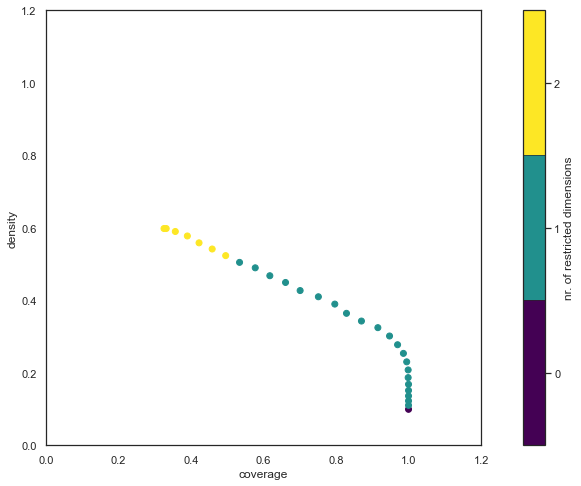

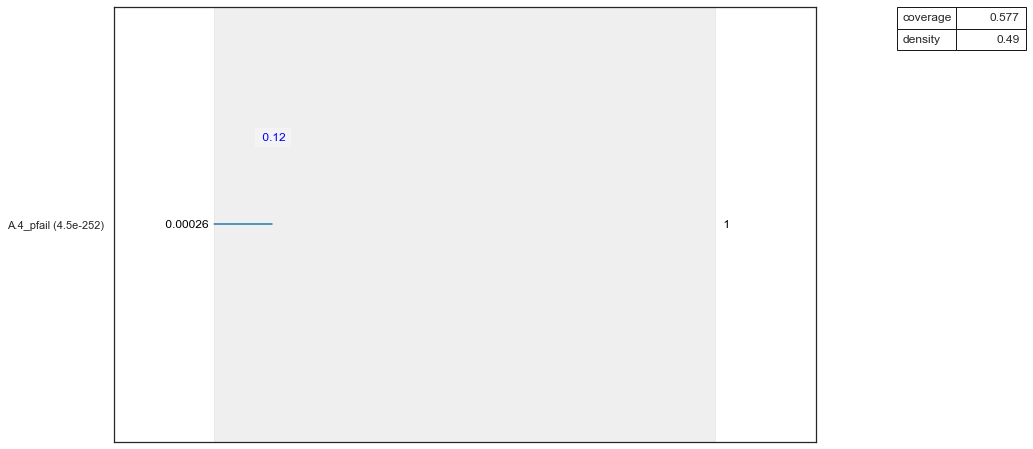

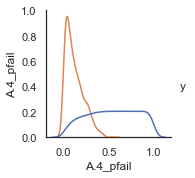

In [54]:
prim_alg = prim.Prim(df_experiments_s1000_p10[uncertainties_columns], df_outcomes_s1000_p10['damages_of_interest'], threshold=0.3, peel_alpha=0.1)
box1 = prim_alg.find_box()

n= 20
box1.show_tradeoff()
box1.inspect(n)
box1.inspect(n, style="graph")
box1.show_pairs_scatter(n)

plt.show()

[MainProcess/INFO] 10000 points remaining, containing 1001 cases of interest
[MainProcess/INFO] mean: 0.5981481481481481, mass: 0.054, coverage: 0.3226773226773227, density: 0.5981481481481481 restricted_dimensions: 2


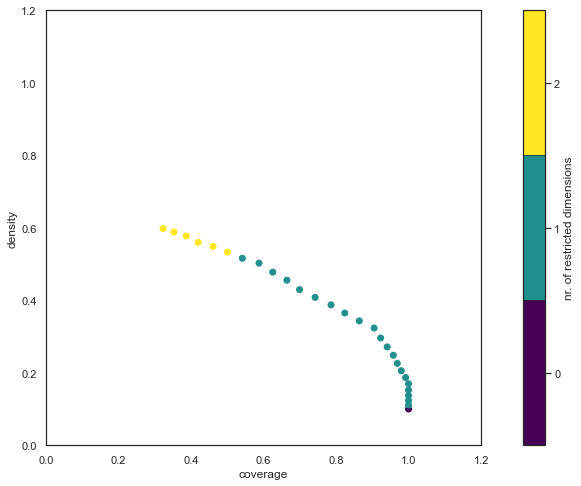

In [55]:
prim_alg = prim.Prim(df_experiments_s1000_p10[uncertainties_columns], df_outcomes_s1000_p10['deaths_of_interest'], threshold=0.3, peel_alpha=0.1)
box1 = prim_alg.find_box()

n= 20
box1.show_tradeoff()
#box1.inspect(n)
#box1.inspect(n, style="graph")
#box1.show_pairs_scatter(n)

plt.show()

[MainProcess/INFO] 10000 points remaining, containing 1024 cases of interest
[MainProcess/INFO] mean: 0.35490196078431374, mass: 0.051, coverage: 0.1767578125, density: 0.35490196078431374 restricted_dimensions: 5


coverage    0.267578
density     0.276768
id                20
mass           0.099
mean        0.276768
res_dim            4
Name: 20, dtype: object

                   box 20                                          
                      min       max                       qp values
A.3_pfail        0.000367  0.180205  [-1.0, 2.7347329233819436e-45]
A.1_pfail        0.000869  0.825366     [-1.0, 0.10828615099034077]
discount rate 0  2.000000  4.500000      [0.0769252186999414, -1.0]
A.4_pfail        0.112666  0.999687     [0.31287558437704777, -1.0]



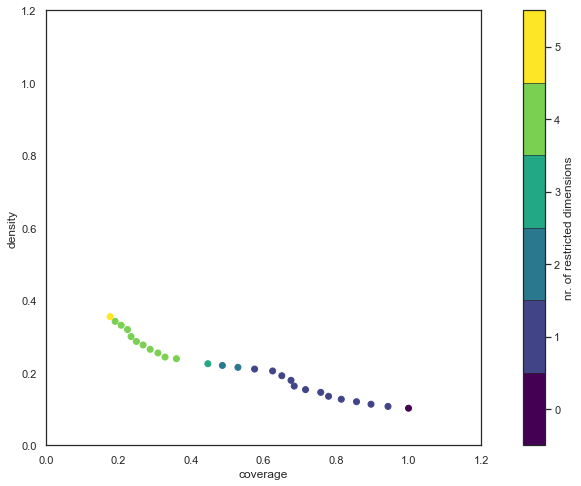

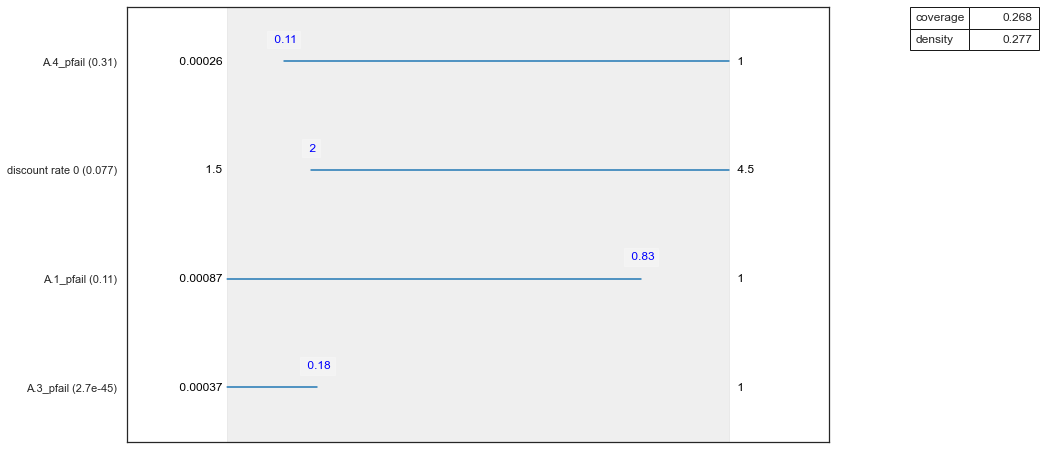

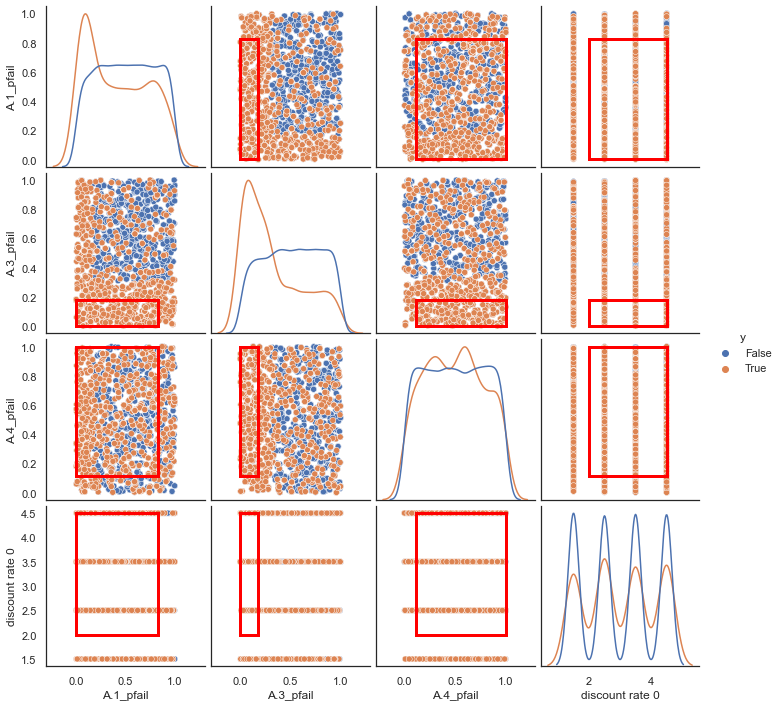

In [63]:
prim_alg = prim.Prim(df_experiments_s1000_p10[uncertainties_columns], df_outcomes_s1000_p10['evacuation_of_interest'], threshold=0.3, peel_alpha=0.1)
box1 = prim_alg.find_box()

n= 20
box1.show_tradeoff()
box1.inspect(n)
box1.inspect(n, style="graph")
box1.show_pairs_scatter(n)

plt.show()

## Dimensional Stacking

C:\Users\Willemijn Tutuarima\miniconda3\envs\gds\lib\site-packages\ema_workbench\analysis\dimensional_stacking.py:423: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  ooi = pd.DataFrame(y[:, np.newaxis], columns=[ooi_label])


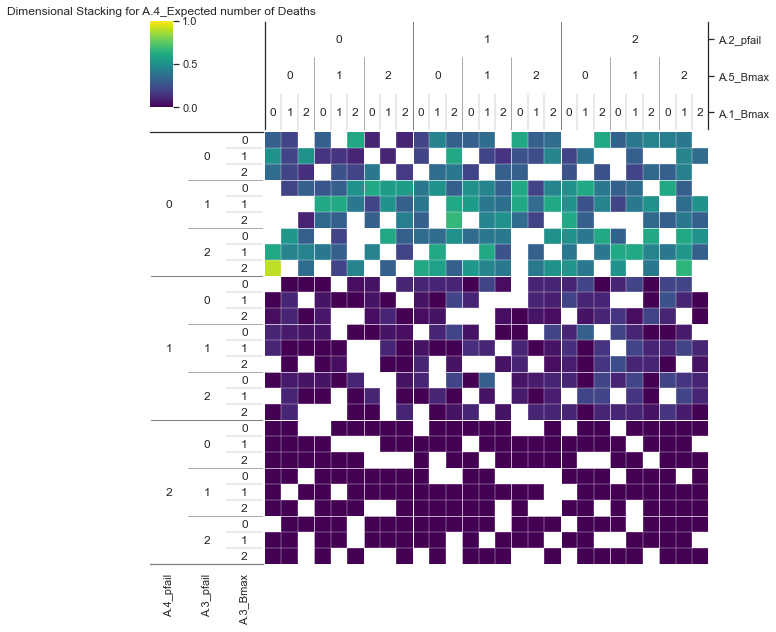

In [28]:
dimensional_stacking.create_pivot_plot(df_experiments_s1000_p10[uncertainties_columns], df_outcomes_s1000_p10['deaths_of_interest'])
plt.title('Dimensional Stacking for A.4_Expected number of Deaths')
plt.show()

C:\Users\Willemijn Tutuarima\miniconda3\envs\gds\lib\site-packages\ema_workbench\analysis\dimensional_stacking.py:423: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  ooi = pd.DataFrame(y[:, np.newaxis], columns=[ooi_label])


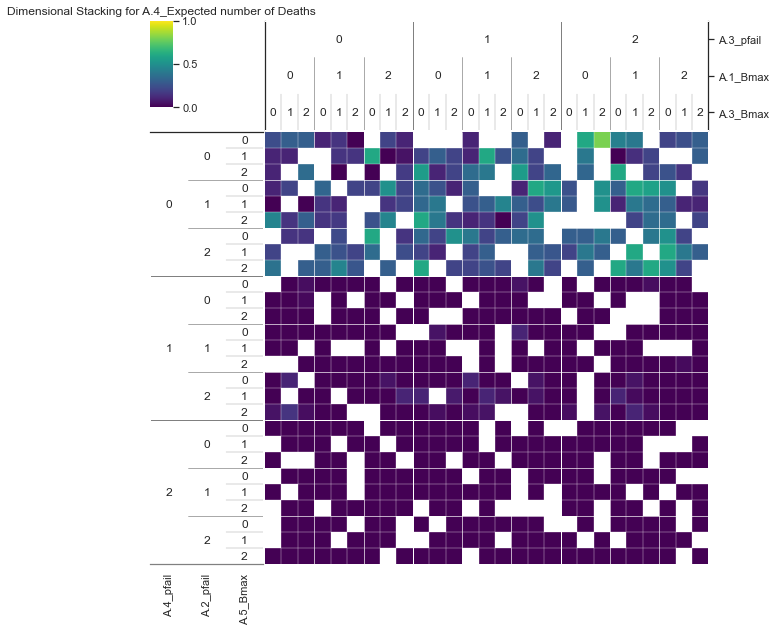

In [29]:
dimensional_stacking.create_pivot_plot(df_experiments_s1000_p10[uncertainties_columns], df_outcomes_s1000_p10['damages_of_interest'])
plt.title('Dimensional Stacking for A.4_Expected number of Deaths')
plt.show()

C:\Users\Willemijn Tutuarima\miniconda3\envs\gds\lib\site-packages\ema_workbench\analysis\dimensional_stacking.py:423: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  ooi = pd.DataFrame(y[:, np.newaxis], columns=[ooi_label])


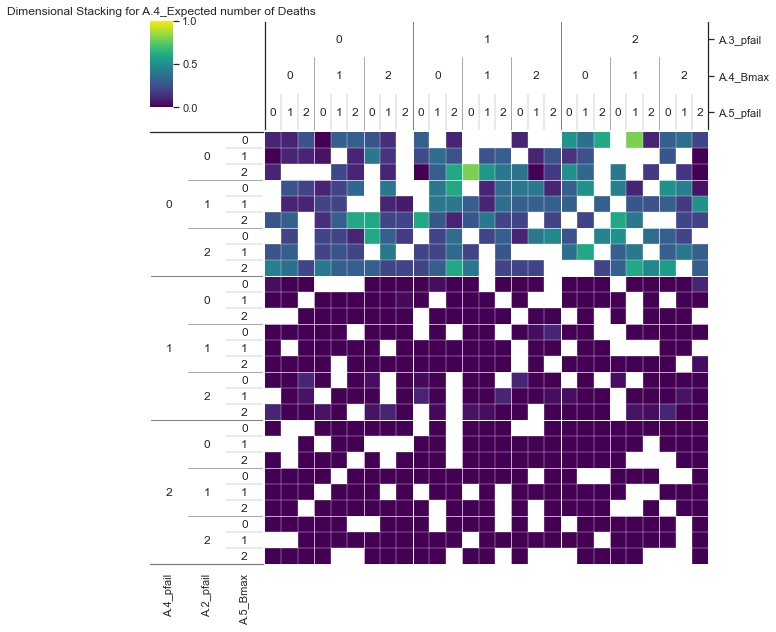

In [30]:
dimensional_stacking.create_pivot_plot(df_experiments_s1000_p10[uncertainties_columns], df_outcomes_s1000_p10['both'])
plt.title('Dimensional Stacking for A.4_Expected number of Deaths')
plt.show()

In [40]:
from ema_workbench.analysis.plotting_util import COLOR_LIST as colors

In [41]:
colors

[(0.12156862745098039, 0.4666666666666667, 0.7058823529411765),
 (1.0, 0.4980392156862745, 0.054901960784313725),
 (0.17254901960784313, 0.6274509803921569, 0.17254901960784313),
 (0.8392156862745098, 0.15294117647058825, 0.1568627450980392),
 (0.5803921568627451, 0.403921568627451, 0.7411764705882353),
 (0.5490196078431373, 0.33725490196078434, 0.29411764705882354),
 (0.8901960784313725, 0.4666666666666667, 0.7607843137254902),
 (0.4980392156862745, 0.4980392156862745, 0.4980392156862745),
 (0.7372549019607844, 0.7411764705882353, 0.13333333333333333),
 (0.09019607843137255, 0.7450980392156863, 0.8117647058823529)]

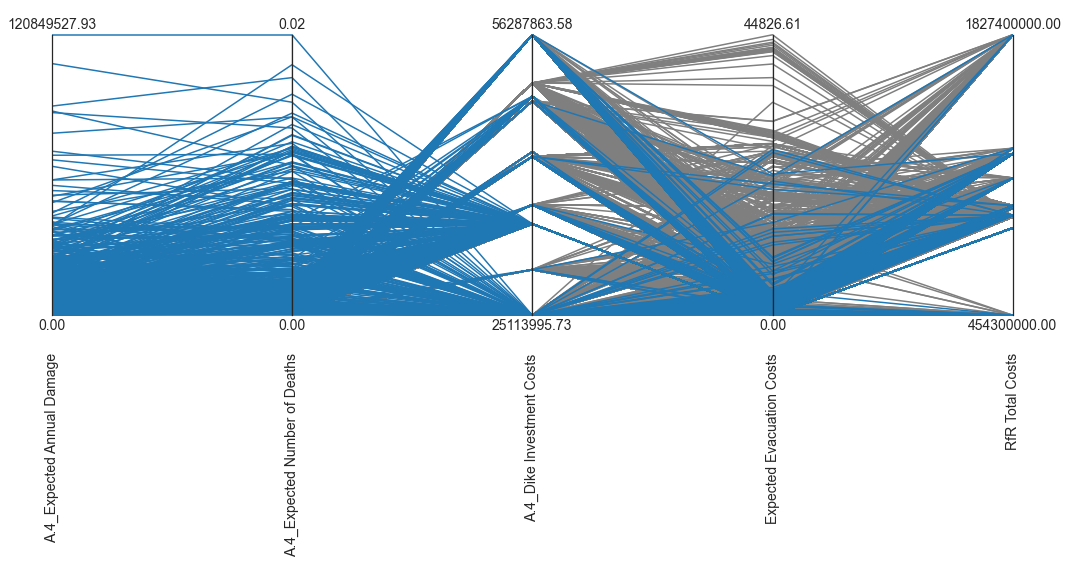

In [50]:
limits = parcoords.get_limits(df_outcomes_s1000_p10[outcomes_of_interest])
axes = parcoords.ParallelAxes(limits)
axes.plot(df_outcomes_s1000_p10[df_outcomes_s1000_p10['deaths_of_interest']==0][outcomes_of_interest], color=colors[7])
axes.plot(df_outcomes_s1000_p10[df_outcomes_s1000_p10['deaths_of_interest']==1][outcomes_of_interest], color=colors[0])

plt.savefig('tradeoff.png')
# we can invert an axis if necessary, so the direction of desirability is the same 
#axes.invert_axis('max_P') 
plt.show()